In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.linear_model
import sklearn.model_selection
import sklearn.tree
import sklearn.utils
import sklearn
from copy import deepcopy
pd.set_option('display.max_columns', None)

In [628]:
from sklearn.utils import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

In [629]:
orig_df = pd.read_csv('./data/all_data_CLEAN.csv')
## Converting columns that were numerical but should be strings (categorical)
orig_df['MSSubClass'] = orig_df['MSSubClass'].astype(str)
orig_df['OverallQual'] = orig_df['OverallQual'].astype(str)
orig_df['OverallCond'] = orig_df['OverallCond'].astype(str)


test_df = orig_df.copy()
test_df
dbl = test_df

### Separating out features by numeric, categorical and ordinal

In [630]:
col_list = list(test_df.columns)

In [631]:
## Nixon & Aleksey provided this list
ordinal =  ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

In [1102]:
## Creating a separate, smaller DF just to look at a few columns for use with prediction
y3 = test_df[['PID','SalePricePerGLA','SalePrice','GrLivArea']]

In [1084]:
## Original category columns, which included Ordinals
org_cat_cols = ['PID', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

In [633]:
## Subtracting out the ordinals from the full categorical list to get the real categoricals that need to be dummified
cat_cols = list(set(org_cat_cols)-set(ordinal))

In [634]:
## Getting the number only columns that Jesse and I cleaned
numer_cols = list(set(test_df.columns) - set(test_df[cat_cols].columns) - set(ordinal))
numer_cols.remove('SalePricePerGLA')

### Splitting target variables to find best predictor

In [635]:
# Here i split out targets just to see which could yield best predictions -- mainly testing with these
y = test_df['SalePrice']
y_psf = test_df['SalePricePerGLA']
y_log = np.log(test_df['SalePrice'])
y_log_psf = np.log(test_df['SalePricePerGLA'])

In [636]:
from sklearn.preprocessing import LabelEncoder

In [637]:
lencoder = LabelEncoder()

### Putting Ordinal Columns in the correct order

In [638]:
ord_colnames = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
ord_dict = {}
ord_dict['LotShape'] = ['IR3', 'IR2', 'IR1', 'Reg']
ord_dict['LandSlope'] = ['Gtl', 'Mod', 'Sev']
ord_dict['OverallQual'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['OverallCond'] = [np.nan, 1,2,3,4,5,6,7,8,9,10]
ord_dict['ExterQual'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['ExterCond'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['BsmtExposure'] = ['NoneListed', 'No', 'Mn', 'Av', 'Gd']
ord_dict['BsmtFinType1'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['BsmtFinType2'] = ['NoneListed', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_dict['HeatingQC'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['KitchenQual'] = [np.nan, 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Functional'] = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
ord_dict['FireplaceQu'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageFinish'] = ['NoneListed', 'Unf', 'RFn', 'Fin']
ord_dict['GarageQual'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['GarageCond'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['PoolQC'] = ['NoneListed', 'Po', 'Fa','TA', 'Gd', 'Ex']
ord_dict['Fence'] = ['NoneListed', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
# Trasforms Labels to Numbers

for i in range(len(ord_colnames)):
    try:
        dbl[ord_colnames[i]] = dbl[ord_colnames[i]].apply(lambda x: ord_dict[ord_colnames[i]].index(x))
    except:
        pass
# Trasforms Numbers back to Labels
# for i in range(len(ord_colnames)):
#     dbl[ord_colnames[i]] = dbl[ord_colnames[i]].apply(lambda x: ord_dict[ord_colnames[i]][x])

dbl[ord_colnames]

,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
0,3,0,6,6,3,3,3,3,1,3,1,3,3,7,4,1,3,3,0,0
1,3,0,5,5,4,3,4,3,2,6,5,3,4,7,0,3,3,3,0,0
2,3,0,5,9,4,3,3,3,1,5,1,5,4,7,0,1,3,1,0,0
3,3,0,4,8,4,4,2,3,1,1,1,4,3,7,0,1,3,3,0,0
4,3,0,8,6,4,3,4,3,1,6,1,5,4,7,0,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,3,0,6,6,3,3,3,3,1,1,1,2,2,7,4,1,2,1,0,0
2548,2,0,3,5,3,3,0,0,0,0,0,5,3,5,4,1,3,3,0,0
2549,3,0,5,6,3,3,3,3,1,4,1,3,3,7,0,1,3,3,0,0
2550,3,0,7,5,4,3,4,3,1,6,1,5,4,7,3,3,3,3,0,0


In [688]:
cat_df = test_df[cat_cols]
numer_df = test_df[numer_cols]
ordinal_df = dbl[ord_colnames]
ordinal_df

,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
0,3,0,6,6,3,3,3,3,1,3,1,3,3,7,4,1,3,3,0,0
1,3,0,5,5,4,3,4,3,2,6,5,3,4,7,0,3,3,3,0,0
2,3,0,5,9,4,3,3,3,1,5,1,5,4,7,0,1,3,1,0,0
3,3,0,4,8,4,4,2,3,1,1,1,4,3,7,0,1,3,3,0,0
4,3,0,8,6,4,3,4,3,1,6,1,5,4,7,0,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,3,0,6,6,3,3,3,3,1,1,1,2,2,7,4,1,2,1,0,0
2548,2,0,3,5,3,3,0,0,0,0,0,5,3,5,4,1,3,3,0,0
2549,3,0,5,6,3,3,3,3,1,4,1,3,3,7,0,1,3,3,0,0
2550,3,0,7,5,4,3,4,3,1,6,1,5,4,7,3,3,3,3,0,0


In [1468]:
cat_df.columns

Index(['SaleCondition', 'Condition1', 'SaleType', 'Heating', 'PID',
       'MiscFeature', 'Exterior1st', 'Street', 'Exterior2nd', 'MSZoning',
       'LandContour', 'GarageType', 'HouseStyle', 'RoofMatl', 'MasVnrType',
       'Electrical', 'Foundation', 'MSSubClass', 'LotConfig', 'PavedDrive',
       'BldgType', 'Alley', 'CentralAir', 'Neighborhood', 'RoofStyle',
       'Condition2'],
      dtype='object')

In [1469]:
numer_df.columns

Index(['BedroomAbvGr', 'YearBuilt', 'PoolArea', 'MasVnrArea', '3SsnPorch',
       'EnclosedPorch', 'KitchenAbvGr', '2ndFlrSF', 'LotArea', 'SalePrice',
       'TotalBsmtSF', 'LowQualFinSF', 'GarageCars', 'TotRmsAbvGrd',
       'GrLivArea', 'GarageYrBlt', 'FullBath', '1stFlrSF', 'LotFrontage',
       'BsmtFullBath', 'HalfBath', 'MoSold', 'YearRemodAdd', 'Fireplaces',
       'BsmtHalfBath', 'OpenPorchSF', 'YrSold', 'BsmtFinSF2', 'GarageArea',
       'WoodDeckSF', 'ScreenPorch', 'BsmtUnfSF', 'BsmtFinSF1', 'Unnamed: 0',
       'MiscVal'],
      dtype='object')

In [1470]:
ordinal_df.columns

Index(['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'],
      dtype='object')

In [643]:
dummy_cats = pd.get_dummies(cat_df,drop_first=True)

In [644]:
dummy_cats

,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn
0,909176150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,905476230,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,911128020,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,535377150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0

In [645]:
numer_df.drop('SalePrice',axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [646]:
numer_df

,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal
0,2,1939,0,0.0,0,0,1,0,7890,856.0,0,2.0,4,856,1939.0,1,856,70.0,1.0,0,3,1950,1,0.0,0,2010,0.0,399.0,0,166,618.0,238.0,0,0
1,2,1984,0,149.0,0,0,1,0,4235,1049.0,0,1.0,5,1049,1984.0,2,1049,42.0,1.0,0,2,1984,0,0.0,105,2009,393.0,266.0,0,0,104.0,552.0,1,0
2,2,1930,0,0.0,86,42,1,0,6060,837.0,0,1.0,5,1001,1930.0,1,1001,60.0,0.0,0,11,2007,0,0.0,0,2007,0.0,216.0,154,0,100.0,737.0,2,0
3,2,1900,0,0.0,0,168,1,322,8146,405.0,0,1.0,6,1039,1940.0,1,717,80.0,0.0,0,5,2003,0,0.0,0,2009,0.0,281.0,0,111,405.0,0.0,3,0
4,3,2001,0,0.0,0,0,1,855,8400,810.0,0,2.0,6,1665,2001.0,2,810,70.0,1.0,1,11,2001,0,0.0,45,2009,0.0,528.0,0,0,167.0,643.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,2,1916,0,0.0,0,0,1,0,8854,952.0,0,1.0,4,952,1916.0,1,952,70.0,0.0,0,5,1950,1,0.0,98,2009,0.0,192.0,0,40,952.0,0.0,2575,0
2548,4,1955,0,0.0,0,0,1,0,13680,0.0,0,2.0,8,1733,1955.0,2,1733,70.0,0.0,0,6,1955,1,0.0,0,2009,0.0,452.0,0,0,0.0,0.0,2576,0
2549,4,1949,0,0.0,0,0,2,1001,6270,1001.0,0,3.0,8,2002,1949.0,2,1001,82.0,0.0,0,8,1950,0,0.0,0,2007,0.0,871.0,0,0,717.0,284.0,2577,0
2550,3,2000,0,144.0,0,0,1,857,8826,985.0,0,2.0,7,1842,2000.0,2,985,70.0,1.0,1,7,2000,1,0.0,96,2007,0.0,486.0,193,0,144.0,841.0,2578,0


### 

In [671]:
## putting together all of the input variables into 1 dataframe, X & looking at correlations
X = pd.concat((dummy_cats,ordinal_df,numer_df),axis=1)
X
# numeric columns correlations
corr = numer_df.corr() 
c1 = corr.abs().unstack()
c1[c1.sort_values(ascending = False)!=1]


BedroomAbvGr  YearBuilt        0.048067
              PoolArea         0.000924
              MasVnrArea       0.104894
              3SsnPorch        0.045162
              EnclosedPorch    0.046876
                                 ...   
MiscVal       WoodDeckSF       0.029213
              ScreenPorch      0.005379
              BsmtUnfSF        0.021201
              BsmtFinSF1       0.015267
              Unnamed: 0       0.001305
Length: 1122, dtype: float64

In [997]:
## Scaling the numeric columns in the input data in order to get more easily interpretable coefficients

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(numer_df)
norm_numer = pd.DataFrame(scaler.transform(numer_df),columns=numer_df.columns)
X_scl_numers = pd.concat((dummy_cats,ordinal_df,norm_numer),axis=1)
X_scl_numers.drop('SalePrice',inplace=True,axis=1)
# X_scl_numers.drop('SalePricePerGLA',inplace=True,axis=1)
numer_df
X_scl_numers

,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal
0,909176150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,6,6,3,3,3,3,1,3,1,3,3,7,4,1,3,3,0,0,-1.032929,-1.058660,-0.05141,-0.562947,-0.099850,-0.361018,-0.199997,-0.794888,-0.271658,-0.432037,-0.091555,0.338441,-1.557577,-1.289758,-1.477801,-1.010774,-0.767874,0.084055,1.085330,-0.75851,-1.178888,-1.66

In [998]:
## Inputs and Targets, train test splits with all combinations
y = test_df['SalePrice']
y_psf = test_df['SalePricePerGLA']

y_log = np.log(test_df['SalePrice'])
y_log_psf = np.log(test_df['SalePricePerGLA'])

In [999]:
import random
random.seed(0)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.25)  ##Not Scaled Numbers, Full Sale $
x_scl_train, x_scl_test, y_scl_train, y_scl_test = train_test_split(X_scl_numers,y,test_size=.25)  ##Scaled Numbers, Full Sale $
x_psf_train, x_psf_test, y_psf_train, y_psf_test = train_test_split(X,y_psf,test_size=.25)  ##Not Scaled Numbers, Sales$ per Sq Ft
x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test = train_test_split(X_scl_numers,y_psf,test_size=.25)  ##Scaled Numbers, Sales$ per Sq Ft

In [1000]:
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(X,y_log,test_size=.25)  ##Not Scaled Numbers, log Full Sale $
x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log = train_test_split(X_scl_numers,y_log,test_size=.25)  ##Scaled Numbers, Full Sale $
x_psf_train_log, x_psf_test_log, y_psf_train_log, y_psf_test_log = train_test_split(X,y_log_psf,test_size=.25)  ##Not Scaled Numbers, log Sales$ per Sq Ft
x_scl_psf_train_log, x_scl_psf_test_log, y_scl_psf_train_log, y_scl_psf_test_log = train_test_split(X_scl_numers,y_log_psf,test_size=.25)  ##Scaled Numbers, log Sales$ per Sq Ft

# Linear 

In [1265]:
## I tried as a baseline on the linear regression model all combinations of inputs / targets 
## just to see the various R^2 scores and Adjusted R^2

In [1126]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
 ##Not Scaled Numbers, Full Sale $
L = [x_train, x_test, y_train, y_test]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3])) 

print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.9293240424162649
0.8985899260125217
0.9202341552462033
0.8458276440810891


In [1125]:
##Scaled Numbers, Full Sale $
L = [x_scl_train, x_scl_test, y_scl_train, y_scl_test]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3])) 


print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.930364563806123
0.8899789108020061
0.9214085018059666
0.8327364347992312


In [1127]:
##Not Scaled Numbers, Sales$ per Sq Ft
L = [x_psf_train, x_psf_test, y_psf_train, y_psf_test]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3])) 


print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.8660745657572678
0.8066562669853866
0.8488499376363736
0.7060621529109576


In [1148]:
##Scaled Numbers, Sales$ per Sq Ft
L2 = [x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test]
ols.fit(L2[0],L2[2])
print(ols.score(L2[0],L2[2]))
print(ols.score(L2[1],L2[3])) 


print(1 - (1-ols.score(L2[0],L2[2]))*(len(L2[2])-1)/(len(L2[2])-L2[0].shape[1]-1))
print(1 - (1-ols.score(L2[1],L2[3]))*(len(L2[3])-1)/(len(L2[3])-L2[1].shape[1]-1))

'SalePrice' in x_scl_psf_train.columns

0.871887983387601
0.7650474943327099
0.8554110396581007
0.6428049018852893


False

In [1129]:
##Not Scaled Numbers, log Full Sale $
L = [x_train_log, x_test_log, y_train_log, y_test_log]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3]))
print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.9473647329290704
0.8938084497493856
0.940595123358886
0.838558430764579


In [1130]:
##Scaled Numbers, Full Sale $
L = [x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3]))
print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.9421757686872972
0.9211993770162006
0.9347387879048965
0.8802004848671117


In [1131]:
##Not Scaled Numbers, log Sales$ per Sq Ft
L = [x_psf_train_log, x_psf_test_log, y_psf_train_log, y_psf_test_log]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2]))
print(ols.score(L[1],L[3]))
print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.8614050015280298
0.8375158174656963
0.8435798040844371
0.7529775076984452


In [1132]:
##Scaled Numbers, log Sales$ per Sq Ft
L = [x_scl_psf_train_log, x_scl_psf_test_log, y_scl_psf_train_log, y_scl_psf_test_log]
ols.fit(L[0],L[2])
print(ols.score(L[0],L[2])) 
print(ols.score(L[1],L[3])) 


print(1 - (1-ols.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ols.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.868454461680989
0.8090594540333259
0.8515359204694585
0.7097156854874191


# Ridge

In [1136]:
## Grid Searching for the best ridge model-- target is the Sales per Sq Ft. as defined by our group

In [1197]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
ridge = Ridge(normalize=True)
ridge_params = {'alpha':[.01,.1,1,10,100,500,1000,10000]}
ridge_cv = GridSearchCV(ridge,ridge_params , scoring='neg_mean_squared_error',cv=20)

In [1198]:
##Scaled Numbers, Sale PSF
L = [x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test]
ridge_cv.fit(L[0],L[2])
ridge_cv.best_estimator_.fit(L[0],L[2])
print(ridge_cv.best_estimator_.score(L[0],L[2]))
print(ridge_cv.best_estimator_.score(L[1],L[3]))


print(1 - (1-ridge_cv.best_estimator_.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ridge_cv.best_estimator_.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))


all_x = pd.concat((x_scl_psf_train, x_scl_psf_test),axis=0)
all_y = pd.concat((y_scl_psf_train, y_scl_psf_test),axis=0)
ttl_preds = list(zip(all_y.index,ridge_cv.best_estimator_.predict(all_x)))
ttl_preds
ridge_cv.best_estimator_.coef_
print("SalePrice" in x_scl_psf_train.columns)
print("SalePricePerGLA" in x_scl_psf_train.columns)

0.8705601137653189
0.777954701305603
0.8539123879841033
0.6624275530588761
False
False


In [1199]:
ttl_preds

[(1395, 132.3881363641297),
 (2055, 95.35011890081158),
 (1179, 150.05689564774593),
 (1772, 78.97441014092989),
 (1957, 138.3057448164805),
 (618, 122.36952424367824),
 (1501, 120.59993799340246),
 (2339, 78.72975475709565),
 (1317, 97.81449334031258),
 (1638, 98.9999239176408),
 (910, 94.57089735161414),
 (305, 148.57093496994838),
 (241, 133.23904649929693),
 (1974, 125.50693705610895),
 (381, 180.0700700754714),
 (252, 101.9471836065213),
 (616, 131.55940632776168),
 (1675, 133.30476199238757),
 (1276, 80.6350773642216),
 (1530, 54.184836732010865),
 (2016, 122.70661534397316),
 (1534, 107.82754980432709),
 (637, 159.72013187311944),
 (416, 105.29542957695544),
 (1927, 125.80189387495746),
 (1012, 98.17875450331566),
 (681, 150.48802285591512),
 (1408, 128.56328746370917),
 (918, 122.82153061550038),
 (2128, 86.41072594894683),
 (1229, 137.39312815854436),
 (1519, 124.75285291540784),
 (2355, 140.68946228757716),
 (1539, 138.72523498369844),
 (2243, 123.99236613397265),
 (447, 95.6

In [1200]:
# nixon_cols = ['HouseStyle_1.5Unf','HouseStyle_1Story','HouseStyle_2.5Fin','HouseStyle_2.5Unf','HouseStyle_2Story','HouseStyle_SFoyer','HouseStyle_SLvl','MSZoning_C (all)','MSZoning_FV','MSZoning_I (all)','MSZoning_RH','MSZoning_RL','MSZoning_RM','LandContour_HLS','LandContour_Low','LandContour_Lvl','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior1st_AsphShn','Exterior1st_BrkComm','Exterior1st_BrkFace','Exterior1st_CBlock','Exterior1st_CemntBd','Exterior1st_HdBoard','Exterior1st_ImStucc','Exterior1st_MetalSd','Exterior1st_Plywood','Exterior1st_PreCast','Exterior1st_Stucco','Exterior1st_VinylSd','Exterior1st_Wd Sdng','Exterior1st_WdShing','Condition2_Feedr','Condition2_Norm','Condition2_PosA','Condition2_PosN','Condition2_RRAe','Condition2_RRAn','Condition2_RRNn','Condition1_Feedr','Condition1_Norm','Condition1_PosA','Condition1_PosN','Condition1_RRAe','Condition1_RRAn','Condition1_RRNe','Condition1_RRNn','GarageType_Attchd','GarageType_Basment','GarageType_BuiltIn','GarageType_CarPort','GarageType_Detchd','GarageType_NoneListed','SaleCondition_Alloca','SaleCondition_Normal','SaleCondition_Partial','MSSubClass_150','MSSubClass_160','MSSubClass_180','MSSubClass_190','MSSubClass_20','MSSubClass_30','MSSubClass_40','MSSubClass_45','MSSubClass_50','MSSubClass_60','MSSubClass_70','MSSubClass_75','MSSubClass_80','MSSubClass_85','MSSubClass_90','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_Greens','Neighborhood_GrnHill','Neighborhood_IDOTRR','Neighborhood_Landmrk','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','2ndFlrSF','LowQualFinSF','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageArea','ScreenPorch','LotShape','OverallCond','ExterQual','BsmtCond','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','Functional']

# Lasso

In [1140]:
## Grid Searching to get best lambda on group defined target

In [1266]:
lasso  = Lasso()
lasso_params = {'alpha':[.01,.1,1,10,100,500,1000,10000]}
lasso_cv = GridSearchCV(lasso,lasso_params , scoring='neg_mean_squared_error',cv=20)
L = [x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test]
lasso_cv.fit(L[0],L[2])
lasso_cv.best_estimator_.fit(L[0],L[2])
print(lasso_cv.best_estimator_.score(L[0],L[2]))
print(lasso_cv.best_estimator_.score(L[1],L[3]))


print(1 - (1-lasso_cv.best_estimator_.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-lasso_cv.best_estimator_.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))


lasso_coefs = list(zip(x_scl_train.columns, lasso_cv.best_estimator_.coef_))
print("SalePrice" in x_scl_psf_train.columns)
print("SalePricePerGLA" in x_scl_psf_train.columns)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20879.342873958172, tolerance: 172.39278470429525
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.5238067036262, tolerance: 168.89168530874454
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96333.15875955588, tolerance: 168.97243496126598
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWa

0.8661932955017588
0.795030407370088
0.8489839376370882
0.6883875166939046
False
False


In [1267]:
df11 = pd.DataFrame(lasso_coefs,columns=['Feat','Coef'])
df11.sort_values(by='Coef',ascending=False)
len(df11[df11['Coef']!=0])

164

In [1268]:
# Getting the lasso (best model) coefficients for the best estimator to see the effects of inputs

In [1269]:
[x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test]
lst_ = list(zip(lasso_cv.best_estimator_.coef_,x_scl_psf_train.columns))
srt_lst_lasso = sorted(lst_,key=lambda x: x[0])
coefs = pd.DataFrame(srt_lst_lasso,columns=['Lasso_Coef','Feature'])
coef_df = coefs
coef_df.sort_values(by='Lasso_Coef',inplace=True)
coef_df[coef_df['Lasso_Coef']!=0]

,Lasso_Coef,Feature
0,-58.058834,Condition2_PosN
1,-11.764112,MSSubClass_160
2,-10.984554,MSZoning_C (all)
3,-10.790805,Foundation_Wood
4,-10.379973,GrLivArea
...,...,...
213,16.833951,Condition2_PosA
214,17.136683,RoofMatl_WdShngl
215,18.259999,SaleCondition_Partial
216,25.791496,Exterior1st_PreCast


In [1237]:
df2 = pd.DataFrame(srt_lst_lasso,columns=['Coef','Feature'])
lrg = df2['Coef'].nlargest(10).index
sml = df2['Coef'].nsmallest(10).index
df3 = pd.concat((df2.iloc[lrg],df2.iloc[sml]),axis=0)
df3.sort_values(by='Coef',ascending=False)

,Coef,Feature
217,60.897380,Neighborhood_GrnHill
216,33.985794,Exterior1st_PreCast
215,13.694678,Neighborhood_Somerst
214,12.417727,SaleCondition_Partial
213,11.211259,Neighborhood_NridgHt
212,10.561205,Neighborhood_StoneBr
211,9.956525,SaleCondition_Alloca
210,9.777819,SaleType_Con
209,9.690448,Exterior1st_BrkFace
208,9.615312,Neighborhood_Greens


In [1270]:
# Charting 10 biggest/smallest coef's 

<AxesSubplot:ylabel='Feature'>

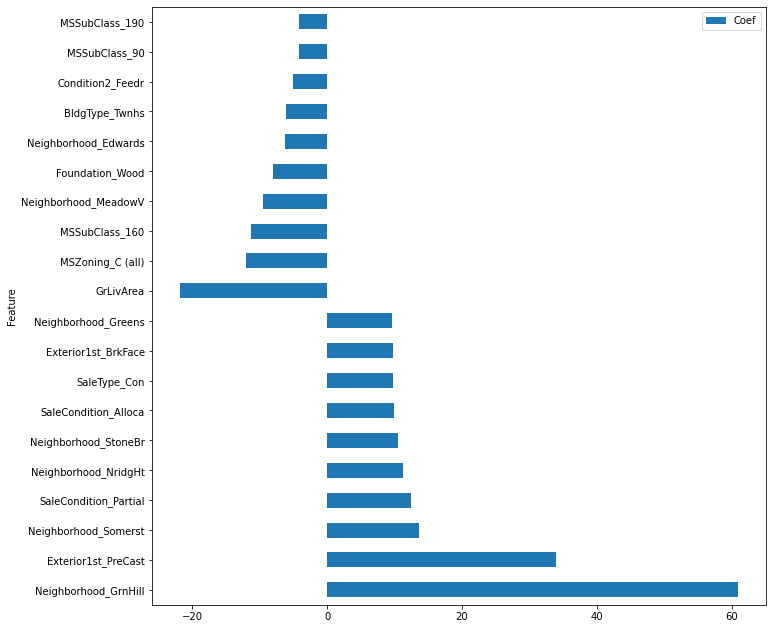

In [1271]:
df3.plot(x='Feature',y='Coef',kind='barh',figsize=(11,11))

In [1011]:
xx = X_scl_numers
yy = test_df['SalePrice']

# Elastic Net

In [1272]:
## Grid Searching to find best elastic net 

In [1274]:
elasticnet = ElasticNet(tol=.5,normalize=True)
alphaRange = np.logspace(-10, 2, 100)
l1_range = np.array((.001,.01,.25,.5,.75,.99,.999,1))
elasticnet_params = {'alpha':alphaRange,'l1_ratio':l1_range}
elasticnet_cv = GridSearchCV(elasticnet,elasticnet_params,cv=20)

L = [x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test]
elasticnet_cv.fit(L[0],L[2])
elasticnet_cv.best_estimator_.fit(L[0],L[2])
print(elasticnet_cv.best_estimator_.score(L[0],L[2]))
print(elasticnet_cv.best_estimator_.score(L[1],L[3]))



print(1 - (1-elasticnet_cv.best_estimator_.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-elasticnet_cv.best_estimator_.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))



KeyboardInterrupt: 

In [421]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# L = [x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log]
# svr = SVR()
# svr_params = {'kernel': ['linear'], 'gamma': [1e-4],'C': [1]}
# # svr_params = {'kernel': ['linear'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000],'epsilon': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9,1]}
# svr_cv = GridSearchCV(svr,svr_params)

In [422]:
# svr_cv.fit(L[0],L[2])

# Predictions using only Numerics

In [1142]:
## Testing to see how strong of predictor ONLY numerics gets out of curiosity

In [207]:
norm_numer.drop('Unnamed: 0',axis=1,inplace=True)

In [208]:
np.random.seed(5)
from sklearn.model_selection import train_test_split
norm_numer
y_psf = test_df['SalePricePerGLA']
x_tr, x_te, y_tr, y_te = train_test_split(norm_numer,y_log_psf,test_size=.25)

In [209]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [210]:
ols = LinearRegression()
ols.fit(x_tr,y_tr)
ols.score(x_tr,y_tr)
ols.score(x_te,y_te)

0.666622156186643

In [211]:
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
alp = np.array((1e-5,1e-4,1e-3,1e-2,1e-1,.2,.25,.5,.75,.9,.99,1,2,5,10,100,1000))
ridge_params={"alpha":alp}
elasticnet_params={"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
lasso_params={'alpha':alp}

In [212]:
elasticnet_cv = GridSearchCV(elasticnet,elasticnet_params,cv=10)
elasticnet_cv.fit(x_tr,y_tr)
elasticnet_cv.best_estimator_.fit(x_tr,y_tr)
print(elasticnet_cv.best_estimator_.score(x_tr,y_tr))
print(elasticnet_cv.best_estimator_.score(x_te,y_te))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.251628943837783, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.378543502583987, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.211025745317478, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.896411235450422, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.25893701458347, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.385027420439446, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.493773711200028, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.266208160400573, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.391474931416518, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conve

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.176389969179773, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.0653863527456, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.099133802583893, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.86012195306087, tolerance: 0.012141940236783277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.853839000783957, tolerance: 0.012131831590032933
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.187052243626436, tolerance: 0.012395115145052427
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.50512645876871, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.58602352743917, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.43601068939451, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Convergen

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.510763950103062, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.96981708667186, tolerance: 0.01218601342992717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.801748850301355, tolerance: 0.012141940236783277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.458580489177887, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.52835706809653, tolerance: 0.01218601342992717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.37897160806827, tolerance: 0.012141940236783277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Convergen

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.900052950578846, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.553879404997621, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.424554848173376, tolerance: 0.01218601342992717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.622523688054716, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.448395668478675, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.965359023509652, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conve

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.73135154353495, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.811838603058014, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.662672107919462, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.539685413925017, tolerance: 0.012131831590032933
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.842229729226652, tolerance: 0.012395115145052427
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.094963381208938, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conve

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.985480162745063, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.68574768635839, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.439500108691306, tolerance: 0.01218601342992717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2516871332234984, tolerance: 0.012395115145052427
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1607714429712495, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.927984023766797, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7631432047171494, tolerance: 0.012141940236783277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.467077566987019, tolerance: 0.012131831590032933
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2179106324508524, tolerance: 0.012395115145052427
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3003912473723283, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3211462163877528, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.622067746198077, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.741348849150043, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.357146215543651, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7994220272741188, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4969796239504447, tolerance: 0.01218601342992717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5499844783020791, tolerance: 0.012141940236783277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4295441009665808, tolerance: 0.012131831590032933
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.986877477393271, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22209017101948803, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13129635185907773, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conv

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0980636899650023, tolerance: 0.012038977016162883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.346545178256676, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.833518892139196, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49876961131207054, tolerance: 0.01199074603420679
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2708463628292037, tolerance: 0.011915235303223231
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.550384343383108, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conve

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.55736344643577, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.53680610976959, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.931422747877896, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converge

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.47783472926908, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.904178122641035, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.259751349689644, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

0.6872019826375262
0.6719080290998105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.19633422234516, tolerance: 0.013323612624922763
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.19633422234516, tolerance: 0.013323612624922763
  model = cd_fast.enet_coordinate_descent(


In [213]:
lasso_cv = GridSearchCV(lasso,lasso_params,cv=10)
lasso_cv.fit(x_tr,y_tr)
lasso_cv.best_estimator_.fit(x_tr,y_tr)
print(lasso_cv.best_estimator_.score(x_tr,y_tr))
print(lasso_cv.best_estimator_.score(x_te,y_te))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2298746574368025, tolerance: 0.011145623355505141
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4261976445950282, tolerance: 0.012044193045407221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.397667144871221, tolerance: 0.01191448588260895
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Converg

0.6871912719046247
0.6718152897537792


In [223]:
ridge_cv = GridSearchCV(ridge,ridge_params,cv=10)
ridge_cv.fit(x_tr,y_tr)
ridge_cv.best_estimator_.fit(x_tr,y_tr)
print(ridge_cv.best_estimator_.score(x_tr,y_tr))
print(ridge_cv.best_estimator_.score(x_te,y_te))

0.6880049464850788
0.668331684824787


# Normalized effect of Only Numerical Inputs on Sales Price per Sqaure foot

In [424]:
ridge_cv.best_estimator_.fit(norm_numer,y_psf)
ridge_cv.best_estimator_.predict(norm_numer)
sorted(list(zip(ridge_cv.best_estimator_.coef_,norm_numer.columns)),key=lambda x: x[0])
effect_df = pd.DataFrame(sorted(list(zip(norm_numer.columns,ridge_cv.best_estimator_.coef_)),key=lambda x: x[0]),columns=['NumericFeat','Effect'])

In [425]:
effect_df.sort_values(by='Effect')

,NumericFeat,Effect
15,GrLivArea,-5.916361
3,BedroomAbvGr,-4.405401
1,2ndFlrSF,-4.202315
0,1stFlrSF,-2.829797
17,KitchenAbvGr,-2.600725
16,HalfBath,-2.012222
11,FullBath,-1.323607
20,LowQualFinSF,-0.997861
25,PoolArea,-0.489890
29,Unnamed: 0,-0.480527


In [426]:
effect_df.sort_values(by='Effect',inplace=True)

In [427]:
effect_df

,NumericFeat,Effect
15,GrLivArea,-5.916361
3,BedroomAbvGr,-4.405401
1,2ndFlrSF,-4.202315
0,1stFlrSF,-2.829797
17,KitchenAbvGr,-2.600725
16,HalfBath,-2.012222
11,FullBath,-1.323607
20,LowQualFinSF,-0.997861
25,PoolArea,-0.489890
29,Unnamed: 0,-0.480527


<BarContainer object of 34 artists>

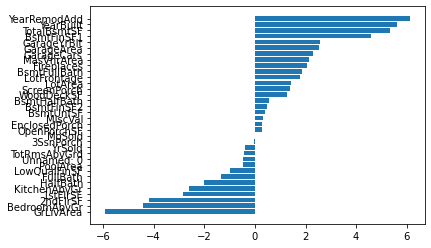

In [1275]:
# effect_df.plot(x=effect_df['Effect'],y=effect_df['Effect'],kind='barh')
x=effect_df['Effect']
y=effect_df['NumericFeat']
plt.barh(y,x)#,figsize=(10,10))

In [1276]:
##Scaled Numbers, Full Sale $ log
import random
random.seed(5)
L = [x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log]
ridge_cv.fit(L[0],L[2])
ridge_cv.best_estimator_.fit(L[0],L[2])
print(ridge_cv.best_estimator_.score(L[0],L[2]))
print(ridge_cv.best_estimator_.score(L[1],L[3]))

print(1 - (1-ridge_cv.best_estimator_.score(L[0],L[2]))*(len(L[2])-1)/(len(L[2])-L[0].shape[1]-1))
print(1 - (1-ridge_cv.best_estimator_.score(L[1],L[3]))*(len(L[3])-1)/(len(L[3])-L[1].shape[1]-1))

0.9386033514456678
0.9196213075838376
0.9307069093307153
0.8778013673768605


In [430]:
x_full = pd.concat((x_scl_train_log, x_scl_test_log),axis=0)
y_full = pd.concat((y_scl_train_log, y_scl_test_log),axis=0)
np.exp(ridge_cv.best_estimator_.predict(x_full)) - np.exp(y_full)

899     -9694.290645
2257    86549.583762
2172    -7454.737656
111     23471.471270
596       242.603549
            ...     
2149    -4001.629073
109      2508.132964
2066    10343.628833
370      1099.996532
1710    29171.897198
Name: SalePrice, Length: 2552, dtype: float64

## Gradient Boost test

In [431]:
import sklearn.ensemble
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [432]:
gbr_params = {'n_estimators':[1000,2500],'learning_rate' :[.05,.1,.2],'max_depth':[4,5,6,7,8]}

In [433]:
L = [x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log]

In [434]:
L = [x_scl_train_log, x_scl_test_log, y_scl_train_log, y_scl_test_log]

In [435]:
gbr_cv = GridSearchCV(gbr,gbr_params)
gbr_cv.fit(x_scl_train_log,y_scl_train_log)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [1000, 2500]})

In [436]:
gbr_cv.best_estimator_.fit(x_scl_train_log,y_scl_train_log)
gbr_cv.best_estimator_.score(x_scl_train_log,y_scl_train_log)

0.9932030871439252

In [437]:
gbr_cv.best_estimator_.score(x_scl_test_log,y_scl_test_log)

0.8845993370963058

In [589]:
to_pred = pd.concat((x_scl_train_log,x_scl_test_log),axis=0)
to_pred.index
targs = pd.concat((y_scl_train_log,y_scl_test_log),axis=0)
to_pred
gbr_cv.best_estimator_.predict(to_pred)

array([135.99989846,  68.18180114, 181.48448909, ..., 136.19715854,
       100.80847116,  79.67160117])

#### Feature importances of GBR

In [438]:
feat_imps = sorted(list(zip(gbr_cv.best_estimator_.feature_importances_,x_scl_train_log)))#, lambda x: x[0])

In [439]:
feat_imps

[(0.0, 'Condition2_PosA'),
 (0.0, 'Condition2_RRAe'),
 (0.0, 'Condition2_RRAn'),
 (0.0, 'Condition2_RRNn'),
 (0.0, 'Exterior1st_ImStucc'),
 (0.0, 'Exterior2nd_CBlock'),
 (0.0, 'HouseStyle_2.5Fin'),
 (0.0, 'MSSubClass_150'),
 (0.0, 'MSZoning_I (all)'),
 (0.0, 'RoofMatl_Membran'),
 (0.0, 'RoofMatl_Metal'),
 (0.0, 'RoofMatl_Roll'),
 (0.0, 'SaleCondition_Alloca'),
 (6.492534352433651e-11, 'MSSubClass_180'),
 (4.0989979190908284e-08, 'Neighborhood_BrDale'),
 (4.7130559787984754e-08, 'RoofMatl_WdShake'),
 (1.6474857025077222e-07, 'Condition2_Feedr'),
 (2.39053857035944e-07, 'SaleType_VWD'),
 (2.505961865432984e-07, 'Heating_Wall'),
 (3.192567015468951e-07, 'RoofStyle_Mansard'),
 (9.032607922458358e-07, 'SaleType_Con'),
 (1.086964083857379e-06, 'BldgType_Twnhs'),
 (1.235787613618664e-06, 'Condition1_RRNe'),
 (1.7084861243454263e-06, 'RoofMatl_Tar&Grv'),
 (1.8492819801964541e-06, 'RoofStyle_Shed'),
 (2.6275227249590913e-06, 'SaleType_ConLw'),
 (2.86159175687234e-06, 'Neighborhood_Landmrk'),
 (

In [440]:
x_scl_psf_train, x_scl_psf_test, y_scl_psf_train, y_scl_psf_test

(            PID  SaleCondition_Alloca  SaleCondition_Normal  \
 364   903225160                     0                     1   
 979   909425140                     0                     1   
 1647  908152060                     0                     1   
 1419  535451110                     0                     1   
 2113  903228090                     0                     1   
 ...         ...                   ...                   ...   
 1411  902103100                     0                     1   
 53    532479020                     0                     1   
 2365  528240050                     0                     1   
 49    533206070                     0                     0   
 2388  902327040                     0                     1   
 
       SaleCondition_Partial  Condition1_Feedr  Condition1_Norm  \
 364                       0                 1                0   
 979                       0                 0                1   
 1647                      0 

In [441]:
gbr_cv = GridSearchCV(gbr,gbr_params)
gbr_cv.fit(x_scl_psf_train,y_scl_psf_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [1000, 2500]})

In [442]:
gbr_cv.best_estimator_.score(x_scl_psf_train,y_scl_psf_train)

0.9999999999806419

In [443]:
gbr_cv.best_estimator_.score(x_scl_psf_test,y_scl_psf_test)

0.8045683035284454

In [836]:
feat_imps_psf = sorted(list(zip(gbr_cv.best_estimator_.feature_importances_,x_scl_psf_test.columns)))

In [837]:
feat_imps_psf

[(0.0, 'Condition2_RRAe'),
 (0.0, 'Condition2_RRAn'),
 (0.0, 'Exterior1st_PreCast'),
 (0.0, 'Exterior2nd_PreCast'),
 (0.0, 'MSSubClass_40'),
 (0.0, 'SaleType_VWD'),
 (6.5934591693788e-14, 'Exterior2nd_AsphShn'),
 (1.2594738102247417e-13, 'Exterior1st_ImStucc'),
 (2.6281970879596206e-11, 'SaleType_ConLw'),
 (4.90645501338845e-11, 'HouseStyle_2.5Fin'),
 (1.9925877795131216e-09, 'Condition2_RRNn'),
 (2.3483062283828355e-09, 'RoofStyle_Shed'),
 (9.108439990282334e-09, 'RoofMatl_Metal'),
 (1.0848360590131005e-08, 'RoofMatl_WdShake'),
 (1.5101966421789646e-08, 'MSZoning_I (all)'),
 (1.6817385636756295e-08, 'RoofMatl_Roll'),
 (1.8179713648759868e-08, 'MSSubClass_150'),
 (3.698882716251231e-08, 'Exterior1st_AsphShn'),
 (5.541780361624175e-08, 'Exterior2nd_CBlock'),
 (7.730168425936729e-08, 'RoofStyle_Mansard'),
 (2.169446087386152e-07, 'RoofMatl_Tar&Grv'),
 (2.484655329310414e-07, 'MSSubClass_180'),
 (3.0531830530303263e-07, 'Condition1_RRNe'),
 (5.85224985188142e-07, 'Electrical_FuseP'),
 (1.

# Top 20 / Bottom 80

In [1277]:
## We are starting to look at the bottom 80% of GrLivArea observations, as detailed in the project proposal
## The bottom 80% tend to follow a more linear pattern from GrLivArea to SlsPrice, and above the 80% threshold, the 
## slope of the line tends to flatten out as GrLivArea increases

In [1143]:
X['GrLivArea']

top_twenty = list(test_df.nlargest((round(len(X)*.2)),'GrLivArea').PID)
bottom_eighty = list(test_df.nsmallest((round(len(X)*.8)),'GrLivArea').PID)


pred_df = pd.DataFrame(np.exp(np.array(ttl_preds)),columns=['ignore','Prediction']).drop('ignore',axis=1)

X.merge(pred_df,left_index=True,right_index=True)
test_df
ttl_preds

<ipython-input-1143-7b9983cd6113>:7: RuntimeWarning: overflow encountered in exp
  pred_df = pd.DataFrame(np.exp(np.array(ttl_preds)),columns=['ignore','Prediction']).drop('ignore',axis=1)


[(1395, 132.3881363641297),
 (2055, 95.35011890081158),
 (1179, 150.05689564774593),
 (1772, 78.97441014092989),
 (1957, 138.3057448164805),
 (618, 122.36952424367824),
 (1501, 120.59993799340246),
 (2339, 78.72975475709565),
 (1317, 97.81449334031258),
 (1638, 98.9999239176408),
 (910, 94.57089735161414),
 (305, 148.57093496994838),
 (241, 133.23904649929693),
 (1974, 125.50693705610895),
 (381, 180.0700700754714),
 (252, 101.9471836065213),
 (616, 131.55940632776168),
 (1675, 133.30476199238757),
 (1276, 80.6350773642216),
 (1530, 54.184836732010865),
 (2016, 122.70661534397316),
 (1534, 107.82754980432709),
 (637, 159.72013187311944),
 (416, 105.29542957695544),
 (1927, 125.80189387495746),
 (1012, 98.17875450331566),
 (681, 150.48802285591512),
 (1408, 128.56328746370917),
 (918, 122.82153061550038),
 (2128, 86.41072594894683),
 (1229, 137.39312815854436),
 (1519, 124.75285291540784),
 (2355, 140.68946228757716),
 (1539, 138.72523498369844),
 (2243, 123.99236613397265),
 (447, 95.6

In [1041]:
print(len(top_twenty))
print(len(bottom_eighty))


510
2042


In [1145]:
## Bringing in the actuals for Avg. sales price per GLA by Neighborhood and then at the total level to 
## start to compare those against our predictions from our models

# Mean / STDev by Nbhd

In [1373]:
avg_nh = pd.DataFrame(bottom80.groupby('Neighborhood')[['SalePricePerGLA','SalePrice']].agg(['mean',np.std]))
avg_nh.columns=['Avg_by_NH', 'SD_by_NH','MeanTtl','STDevTtl']
avg_nh = avg_nh.reset_index()
avg_nh

top_twenty
bottom_eighty

pred_df = pd.DataFrame(ttl_preds,columns=['Index','Prediction'])
bottom80 = test_df[test_df['PID'].isin(bottom_eighty)]
underval_start = pd.merge(bottom80,avg_nh,left_on='Neighborhood',right_on='Neighborhood')
actuals_preds = pd.merge(underval_start,pred_df,left_on='Unnamed: 0',right_on='Index')
actuals_preds

pop_mean = np.mean(bottom80['SalePricePerGLA'])
pop_stdev = np.std(bottom80['SalePricePerGLA'])
avg_nh
bottom80.dropna(inplace=True)
bottom80.GrLivArea

<ipython-input-1373-e0ff6ef084b6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom80.dropna(inplace=True)


0        856
1       1049
2       1001
3       1039
4       1665
        ... 
2544    1242
2545     816
2546    1724
2547     952
2548    1733
Name: GrLivArea, Length: 2042, dtype: int64

In [1374]:
underval_start

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl
0,0,909176150,856,126000,30,RL,70.0,7890,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,1,3,238.0,1,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,Detchd,1939.0,1,2.0,399.0,3,3,Y,0,0,0,0,166,0,0,0,NoneListed,0,3,2010,WD,Normal,147.196262,95.929130,23.465759,125823.757576,26525.859924
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924
2,238,909253190,790,91000,30,RL,52.0,6292,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,2,3,384.0,1,0.0,384.0,768.0,GasA,3,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1925.0,1,1.0,160.0,2,3,Y,0,141,0,0,0,0,0,0,NoneListed,0,4,2008,WD,Normal,115.189873,95.929130,23.465759,125823.757576,26525.859924
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,1413,909451180,1229,124000,160,RM,24.0,1300,Pave,NoneListed,3,Lvl,Inside,0,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,1,5,285.0,1,0.0,276.0,561.0,GasA,3,Y,SBrkr,561,668,0,0.0,0.0,1,1,2,1,3,5,7,1,3,Attchd,1980.0,3,2.0,462.0,3,3,Y,150,0,0,0,0,0,0,4,NoneListed,0,5,2009,WD,Normal,100.895037,126.218703,34.476442,143590.000000,30158.523763
2038,1629,909455030,1034,185000,120,RM,35.0,3907,Pave,NoneListed,2,HLS,Inside,1,Blueste,Norm,Norm,TwnhsE,1Story,8,6,1989,1989,Gable,CompShg,HdBoard,HdBoard,None,0.0,4,3,CBlock,4,3,4,6,747.0,1,0.0,235.0,982.0,GasA,4,Y,SBrkr,1034,0,0,1.0,0.0,1,0,1,1,4,4,7,1,3,Attchd,1989.0,3,2.0,598.0,3,3,Y,141,36,0,0,0,0,0,0,NoneListed,0,4,2010,WD,Normal,178.916828,126.218703,34.476442,143590.000000,30158.523763
2039,1752,909

In [1320]:
underval_start['SDs_away'] = (underval_start['SalePricePerGLA'] - underval_start['Avg_by_NH']) / underval_start['SD_by_NH']
undervalued = underval_start[underval_start['SDs_away']<-1]
overval = underval_start[underval_start['SDs_away']>1]

undervalued.describe()

,Unnamed: 0,PID,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,SDs_away
count,308.000000,3.080000e+02,308.000000,308.000000,308.000000,308.000000,308.00000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,1314.814935,7.289223e+08,1467.487013,131764.522727,63.311688,8912.675325,2.74026,0.042208,1961.688312,1975.071429,68.902597,3.172078,3.016234,3.051948,2.675325,1.191558,2.441558,224.204545,1.123377,32.772727,594.383117,851.360390,3.775974,1044.366883,416.100649,7.019481,0.201299,0.045455,1.551948,0.438312,3.009740,1.155844,3.201299,6.558442,6.590909,0.357143,1.071429,1967.756494,1.305195,1.454545,381.220779,2.529221,2.532468,57.405844,31.688312,27.847403,1.038961,8.902597,1.194805,0.009740,0.529221,20.535714,6.201299,2007.879870,88.931514,121.496716,22.179467,154973.259699,32333.914301,-1.466688
std,741.526589,1.879872e+08,288.210230,41216.807970,20.224560,5040.099256,0.44656,0.231489,29.911600,20.868943,142.709485,0.477097,0.422952,1.066470,0.872177,0.769318,1.999958,316.753823,0.776931,118.709814,449.828519,405.492506,1.007371,332.808381,354.938018,52.852628,0.409653,0.208638,0.504600,0.534869,0.878574,0.363298,0.539995,1.296384,1.049980,0.537561,1.571767,25.425803,0.821756,0.757941,202.718069,1.012523,1.018838,95.137211,56.544182,64.327841,18.233692,40.213238,20.968746,0.170941,1.159491,116.560879,2.788716,1.348851,19.285695,17.103321,3.965148,36068.897747,10918.442607,0.432716
min,15.000000,5.263021e+08,498.000000,12789.000000,21.000000,1476.000000,1.00000,0.000000,1875.000000,1950.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,483.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,15.371394,94.768499,9.092847,95183.030303,9558.769290,-3.870698
25%,692.250000,5.341284e+08,1310.500000,101350.000000,53.000000,6872.750000,2.00000,0.000000,1941.000000,1952.500000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,241.000000,689.000000,3.000000,807.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,3.000000,6.000000,7.000000,0.000000,0.000000,1950.000000,1.000000,1.000000,266.250000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,74.979968,105.425513,19.370182,125853.450331,23826.673750,-1.668105
50%,1308.500000,9.021296e+08,1557.000000,133250.000000,65.000000,8920.500000,3.00000,0.000000,1963.000000,1972.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,570.500000,824.500000,4.000000,945.500000,541.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.0

In [1321]:
overval.describe()

,Unnamed: 0,PID,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,SDs_away
count,317.000000,3.170000e+02,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.0,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.0,317.0,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,1304.905363,7.324110e+08,1103.031546,177264.495268,64.078864,9098.722397,2.596215,0.066246,1973.375394,1987.798107,80.526814,3.400631,3.164038,3.630915,3.028391,2.119874,4.580442,629.246057,1.473186,61.671924,357.271293,1048.189274,4.223975,1083.211356,19.820189,0.0,0.681388,0.088328,1.312303,0.100946,2.217666,1.006309,3.536278,5.135647,6.977918,0.473186,1.381703,1977.897476,1.690852,1.747634,470.716088,2.870662,2.880126,102.015773,37.384858,12.630915,4.457413,19.914826,0.0,0.0,0.668770,94.006309,5.990536,2008.006309,157.087690,121.792219,22.427842,156548.087280,33082.659003,1.580102
std,757.721349,1.886729e+08,322.174709,72265.560392,18.807278,5283.870523,0.552083,0.273334,26.486821,19.834527,138.546010,0.590322,0.395665,0.724388,0.268284,1.249614,1.795915,420.081626,1.215697,183.539271,333.299883,342.100588,0.922808,327.787804,105.184990,0.0,0.518091,0.284220,0.484187,0.301734,0.688929,0.112331,0.704490,1.072037,0.244208,0.613720,1.750962,24.415374,0.881784,0.719992,200.093969,0.630695,0.640028,114.308639,60.195963,38.600839,30.788410,64.023401,0.0,0.0,1.285534,924.548491,2.611423,1.314461,22.782363,17.856968,4.029710,38168.438765,11547.276254,0.536314
min,0.000000,5.263020e+08,438.000000,60000.000000,21.000000,1477.000000,1.000000,0.000000,1900.000000,1950.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,290.000000,2.000000,438.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,4.000000,0.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,2006.000000,107.396150,94.768499,9.092847,95183.030303,9558.769290,1.002723
25%,636.000000,5.323782e+08,864.000000,129900.000000,51.000000,6762.000000,2.000000,0.000000,1957.000000,1972.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,4.000000,292.000000,1.000000,0.000000,115.000000,833.000000,3.000000,854.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,4.000000,7.000000,0.000000,0.000000,1963.000000,1.000000,1.000000,319.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.000000,2007.000000,142.241379,105.425513,19.370182,125853.450331,23826.673750,1.202020
50%,1350.000000,9.022051e+08,1020.000000,149000.000000,65.000000,8520.000000,3.000000,0.000000,1972.000000,1997.000000,0.000000,3.000000,3.000000,4.000000,3.000000,1.000000,5.000000,660.000000,1.000000,0.000000,252.000000,949.000000,5.000000,992.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,7.000000,0.000000,0.000000,1978.000000,1.000000

In [1322]:
actuals_preds

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction
0,0,909176150,856,126000,30,RL,70.0,7890,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,1,3,238.0,1,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,Detchd,1939.0,1,2.0,399.0,3,3,Y,0,0,0,0,166,0,0,0,NoneListed,0,3,2010,WD,Normal,147.196262,95.929130,23.465759,125823.757576,26525.859924,0,132.516351
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435
2,238,909253190,790,91000,30,RL,52.0,6292,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,2,3,384.0,1,0.0,384.0,768.0,GasA,3,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1925.0,1,1.0,160.0,2,3,Y,0,141,0,0,0,0,0,0,NoneListed,0,4,2008,WD,Normal,115.189873,95.929130,23.465759,125823.757576,26525.859924,238,113.107170
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924,334,157.326930
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924,338,74.089889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1413,909451180,1229,124000,160,RM,24.0,1300,Pave,NoneListed,3,Lvl,Inside,0,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,1,5,285.0,1,0.0,276.0,561.0,GasA,3,Y,SBrkr,561,668,0,0.0,0.0,1,1,2,1,3,5,7,1,3,Attchd,1980.0,3,2.0,462.0,3,3,Y,150,0,0,0,0,0,0,4,NoneListed,0,5,2009,WD,Normal,100.895037,126.218703,34.476442,143590.000000,30158.523763,1413,55.638842
2016,1629,909455030,1034,185000,120,RM,35.0,3907,Pave,NoneListed,2,HLS,Inside,1,Blueste,Norm,Norm,TwnhsE,1Story,8,6,1989,1989,Gable,CompShg,HdBoard,HdBoard,None,0.0,4,3,CBlock,4,3,4,6,747.0,1,0.0,235.0,982.0,GasA,4,Y,SBrkr,1034,0,0,1.0,0.0,1,0,1,1,4,4,7,1,3,Attchd,1989.0,3,2.0,598.0,3,3,Y,141,36,0,

In [1323]:
## Changeable features homeowners or real estate investors can improve in order go get a higher Sales Price or Sale Price per Sq Ft
changeable = ['Condition1', 'Condition2','OverallQual', 'OverallCond','YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd','MasVnrType', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'BsmtFinType1','BsmtFinType2', 'Heating','HeatingQC', 'CentralAir','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenQual','FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond','PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 'SaleType',]

In [1324]:
pd.DataFrame(srt_lst_lasso,columns=['Coef','Feat'])
chg_df = pd.DataFrame(changeable,columns=['Changeable'])
chg_df['Yes']='Yes'
chg_df

,Changeable,Yes
0,Condition1,Yes
1,Condition2,Yes
2,OverallQual,Yes
3,OverallCond,Yes
4,YearRemodAdd,Yes
5,RoofStyle,Yes
6,RoofMatl,Yes
7,Exterior1st,Yes
8,Exterior2nd,Yes
9,MasVnrType,Yes


In [1325]:
## Get an undervalued list of homes based on the model i have
## Have Feature importances / coefs per model 
## get most important changeable features for investment

In [1326]:
actuals_preds

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction
0,0,909176150,856,126000,30,RL,70.0,7890,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,1,3,238.0,1,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,Detchd,1939.0,1,2.0,399.0,3,3,Y,0,0,0,0,166,0,0,0,NoneListed,0,3,2010,WD,Normal,147.196262,95.929130,23.465759,125823.757576,26525.859924,0,132.516351
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435
2,238,909253190,790,91000,30,RL,52.0,6292,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,2,3,384.0,1,0.0,384.0,768.0,GasA,3,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1925.0,1,1.0,160.0,2,3,Y,0,141,0,0,0,0,0,0,NoneListed,0,4,2008,WD,Normal,115.189873,95.929130,23.465759,125823.757576,26525.859924,238,113.107170
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924,334,157.326930
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924,338,74.089889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1413,909451180,1229,124000,160,RM,24.0,1300,Pave,NoneListed,3,Lvl,Inside,0,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,1,5,285.0,1,0.0,276.0,561.0,GasA,3,Y,SBrkr,561,668,0,0.0,0.0,1,1,2,1,3,5,7,1,3,Attchd,1980.0,3,2.0,462.0,3,3,Y,150,0,0,0,0,0,0,4,NoneListed,0,5,2009,WD,Normal,100.895037,126.218703,34.476442,143590.000000,30158.523763,1413,55.638842
2016,1629,909455030,1034,185000,120,RM,35.0,3907,Pave,NoneListed,2,HLS,Inside,1,Blueste,Norm,Norm,TwnhsE,1Story,8,6,1989,1989,Gable,CompShg,HdBoard,HdBoard,None,0.0,4,3,CBlock,4,3,4,6,747.0,1,0.0,235.0,982.0,GasA,4,Y,SBrkr,1034,0,0,1.0,0.0,1,0,1,1,4,4,7,1,3,Attchd,1989.0,3,2.0,598.0,3,3,Y,141,36,0,

In [1327]:
actuals_preds['FullSPPred'] = actuals_preds['Prediction'] * actuals_preds['GrLivArea']

In [1328]:
actuals_preds['NullPredTtlNH'] = actuals_preds['Avg_by_NH'] * actuals_preds['GrLivArea']

In [1329]:
actuals_preds['TtlPopMean'] = pop_mean
actuals_preds['TtlPopSTDev'] = pop_stdev
actuals_preds

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction,FullSPPred,NullPredTtlNH,TtlPopMean,TtlPopSTDev
0,0,909176150,856,126000,30,RL,70.0,7890,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,1,3,238.0,1,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,Detchd,1939.0,1,2.0,399.0,3,3,Y,0,0,0,0,166,0,0,0,NoneListed,0,3,2010,WD,Normal,147.196262,95.929130,23.465759,125823.757576,26525.859924,0,132.516351,113433.996402,82115.335520,122.028553,28.525077
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435,207382.293812,146004.136286,122.028553,28.525077
2,238,909253190,790,91000,30,RL,52.0,6292,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,2,3,384.0,1,0.0,384.0,768.0,GasA,3,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1925.0,1,1.0,160.0,2,3,Y,0,141,0,0,0,0,0,0,NoneListed,0,4,2008,WD,Normal,115.189873,95.929130,23.465759,125823.757576,26525.859924,238,113.107170,89354.664440,75784.012921,122.028553,28.525077
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924,334,157.326930,230483.951971,140536.175860,122.028553,28.525077
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924,338,74.089889,114913.418038,148786.081064,122.028553,28.525077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1413,909451180,1229,124000,160,RM,24.0,1300,Pave,NoneListed,3,Lvl,Inside,0,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,1,5,285.0,1,0.0,276.0,561.0,GasA,3,Y,SBrkr,561,668,0,0.0,0.0,1,1,2,1,3,5,7,1,3,Attchd,1980.0,3,2.0,462.0,3,3,Y,150,0,0,0,0,0,0,4,NoneListed,0,5,2009,WD,Normal,100.895037,126.218703,34.476442,143590.000000,30158.523763,1413,55.

In [1330]:
actuals_preds['ObsNullPred'] = actuals_preds['TtlPopMean'] * actuals_preds['GrLivArea']
actuals_preds['ObsNullSTdev'] = actuals_preds['TtlPopSTDev'] * actuals_preds['GrLivArea']
actuals_preds

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction,FullSPPred,NullPredTtlNH,TtlPopMean,TtlPopSTDev,ObsNullPred,ObsNullSTdev
0,0,909176150,856,126000,30,RL,70.0,7890,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,1,3,238.0,1,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,Detchd,1939.0,1,2.0,399.0,3,3,Y,0,0,0,0,166,0,0,0,NoneListed,0,3,2010,WD,Normal,147.196262,95.929130,23.465759,125823.757576,26525.859924,0,132.516351,113433.996402,82115.335520,122.028553,28.525077,104456.441662,24417.465723
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435,207382.293812,146004.136286,122.028553,28.525077,185727.458189,43415.166858
2,238,909253190,790,91000,30,RL,52.0,6292,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1Story,6,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,2,3,384.0,1,0.0,384.0,768.0,GasA,3,N,SBrkr,790,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1925.0,1,1.0,160.0,2,3,Y,0,141,0,0,0,0,0,0,NoneListed,0,4,2008,WD,Normal,115.189873,95.929130,23.465759,125823.757576,26525.859924,238,113.107170,89354.664440,75784.012921,122.028553,28.525077,96402.557142,22534.810656
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924,334,157.326930,230483.951971,140536.175860,122.028553,28.525077,178771.830649,41789.237482
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924,338,74.089889,114913.418038,148786.081064,122.028553,28.525077,189266.286236,44242.394085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1413,909451180,1229,124000,160,RM,24.0,1300,Pave,NoneListed,3,Lvl,Inside,0,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,1,5,285.0,1,0.0,276.0,561.0,GasA,3,Y,SBrkr,561,668,0,0.0,0.

In [1331]:
actuals_preds['NHSTDevCalc'] = ((actuals_preds['SalePricePerGLA'] - actuals_preds['Avg_by_NH']))/actuals_preds['SD_by_NH']
actuals_preds['TtlSTDevCalc'] =  (actuals_preds['SalePricePerGLA'] - actuals_preds['TtlPopMean']) / actuals_preds['TtlPopSTDev']

In [1332]:
## NHSTDevCalc
## TtlSTDevCalc
nbhd_undervalued = actuals_preds[actuals_preds['NHSTDevCalc']<-1]
ttl_undervalued = actuals_preds[actuals_preds['TtlSTDevCalc']<-1]

In [1333]:
nbhd_undervalued

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction,FullSPPred,NullPredTtlNH,TtlPopMean,TtlPopSTDev,ObsNullPred,ObsNullSTdev,NHSTDevCalc,TtlSTDevCalc
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435,207382.293812,146004.136286,122.028553,28.525077,185727.458189,43415.166858,-1.232095,-1.928530
12,1393,904302260,1392,100000,190,RL,60.0,9900,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,2fmCon,1.5Fin,5,4,1915,1950,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,3,1,3,1026.0,1,0.0,186.0,1212.0,GasA,3,N,SBrkr,1212,180,0,1.0,0.0,1,0,3,1,3,6,7,0,0,NoneListed,1939.5,0,0.0,0.0,0,0,N,0,0,168,0,0,0,0,0,NoneListed,0,2,2010,ConLD,Normal,71.839080,95.929130,23.465759,125823.757576,26525.859924,1393,85.851829,119505.745492,133533.349350,122.028553,28.525077,169863.746255,39706.906877,-1.026604,-1.759486
21,1883,909250030,1666,100000,50,RL,51.0,9839,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Feedr,Norm,1Fam,1.5Fin,5,2,1931,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,3,2,1,1,0.0,1,0.0,894.0,894.0,GasA,5,Y,SBrkr,894,772,0,1.0,0.0,1,0,3,1,3,7,7,1,4,NoneListed,1941.0,0,0.0,0.0,0,0,N,0,156,0,0,0,0,0,0,NoneListed,0,5,2010,WD,Normal,60.024010,95.929130,23.465759,125823.757576,26525.859924,1883,69.506612,115798.015595,159817.931046,122.028553,28.525077,203299.569871,47522.777915,-1.530107,-2.173685
26,2159,909256060,1639,115000,50,RL,51.0,10480,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,6,5,1936,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,3,3,1,1,0.0,1,0.0,1064.0,1064.0,GasA,5,Y,FuseA,1166,0,473,0.0,0.0,1,0,3,1,3,6,2,0,0,Detchd,1936.0,1,1.0,240.0,3,3,Y,0,0,0,0,0,0,0,0,NoneListed,0,3,2008,WD,Normal,70.164735,95.929130,23.465759,125823.757576,26525.859924,2159,140.828965,230818.673021,157227.844529,122.028553,28.525077,200004.798930,46752.600842,-1.097957,-1.818183
30,2365,904352190,1680,114900,190,RH,60.0,6048,Pave,NoneListed,3,Lvl,Corner,0,SWISU,Artery,Norm,2fmCon,1.5Fin,5,7,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,4,BrkTil,3,3,2,2,736.0,1,0.0,120.0,856.0,GasA,4,Y,SBrkr,936,744,0,1.0,0.0,2,0,2,2,3,7,7,1,4,Detchd,1910.0,1,2.0,450.0,3,2,P,56,144,0,0,0,0,0,0,NoneListed,0,6,2010,COD,Normal,68.392857,95.929130,23.465759,125823.757576,26525.859924,2365,112.103521,188333.915512,161160.938870,122.028553,28.525077,205007.969618,47922.128990,-1.173466,-1.880300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,2007,533252020,1208,165000,20,RL,70.0,11250,Pave,NoneListed,2

In [1334]:
ttl_undervalued

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction,FullSPPred,NullPredTtlNH,TtlPopMean,TtlPopSTDev,ObsNullPred,ObsNullSTdev,NHSTDevCalc,TtlSTDevCalc
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435,207382.293812,146004.136286,122.028553,28.525077,185727.458189,43415.166858,-1.232095,-1.928530
3,334,909256010,1465,131000,50,RL,84.0,10164,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1939,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,2,3,2,646.0,1,0.0,346.0,992.0,GasA,2,Y,SBrkr,992,473,0,0.0,0.0,2,0,3,1,3,6,7,2,3,Detchd,1939.0,1,1.0,240.0,3,3,Y,0,126,0,0,0,0,0,0,NoneListed,0,7,2006,WD,Normal,89.419795,95.929130,23.465759,125823.757576,26525.859924,334,157.326930,230483.951971,140536.175860,122.028553,28.525077,178771.830649,41789.237482,-0.277397,-1.143161
4,338,909176180,1551,137000,50,RL,60.0,10890,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1938,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,2,3,1,2,930.0,1,0.0,128.0,1058.0,GasA,3,Y,SBrkr,1058,493,0,1.0,0.0,2,0,3,1,2,6,7,0,0,Detchd,1938.0,1,1.0,240.0,2,3,Y,0,0,0,0,0,0,0,3,NoneListed,0,7,2006,WD,Normal,88.330110,95.929130,23.465759,125823.757576,26525.859924,338,74.089889,114913.418038,148786.081064,122.028553,28.525077,189266.286236,44242.394085,-0.323834,-1.181362
7,928,909100110,1647,128000,70,RL,66.0,6858,Pave,NoneListed,3,Bnk,Corner,0,SWISU,Norm,Norm,1Fam,2Story,6,4,1915,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,PConc,4,3,1,1,0.0,1,0.0,806.0,806.0,GasA,3,N,FuseF,841,806,0,1.0,0.0,1,1,4,1,2,6,7,0,0,Detchd,1920.0,1,1.0,216.0,3,3,Y,0,66,136,0,0,0,0,0,NoneListed,0,5,2010,WD,Normal,77.717061,95.929130,23.465759,125823.757576,26525.859924,928,136.234029,224377.445852,157995.277571,122.028553,28.525077,200981.027357,46980.801456,-0.776113,-1.553422
9,991,904302020,879,80000,30,RL,50.0,5220,Pave,NoneListed,2,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1Story,5,3,1936,1950,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,3,1,1,0.0,1,0.0,830.0,830.0,GasA,4,Y,SBrkr,879,0,0,0.0,0.0,1,0,2,1,3,4,7,0,0,Detchd,1936.0,1,1.0,180.0,3,3,P,0,108,0,0,0,0,0,0,NoneListed,0,1,2006,WD,Normal,91.012514,95.929130,23.465759,125823.757576,26525.859924,991,123.717843,108747.984012,84321.705516,122.028553,28.525077,107263.098389,25073.542489,-0.209523,-1.087325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,110,904300150,1224,107500,50,RL,72.0,10632,Pave,NoneListed,2,Lvl,Inside,0,ClearCr,Norm,Norm,1Fam,

In [1179]:
actuals_preds['PredPct'] = (actuals_preds['SalePricePerGLA'] / actuals_preds['Prediction'] ) -1

In [1180]:
actuals_preds[actuals_preds['PredPct']<-.50]

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePricePerGLA,Avg_by_NH,SD_by_NH,MeanTtl,STDevTtl,Index,Prediction,FullSPPred,NullPredTtlNH,TtlPopMean,TtlPopSTDev,ObsNullPred,ObsNullSTdev,NHSTDevCalc,TtlSTDevCalc,PredPct
1,219,909250210,1522,102000,50,RL,60.0,6000,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,2,BrkTil,3,3,1,1,0.0,1,0.0,1008.0,1008.0,GasA,5,Y,SBrkr,1008,0,514,0.0,0.0,2,0,4,1,3,7,7,0,0,NoneListed,1926.0,0,0.0,0.0,0,0,P,0,0,138,0,0,0,0,0,NoneListed,0,6,2006,WD,Normal,67.017083,95.929130,23.465759,125823.757576,26525.859924,219,136.256435,207382.293812,146004.136286,122.028553,28.525077,185727.458189,43415.166858,-1.232095,-1.928530,-0.508155
15,1604,909175100,1694,136500,50,RL,60.0,8400,Pave,NoneListed,3,Bnk,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,6,5,1925,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,PConc,3,3,1,3,423.0,1,0.0,758.0,1181.0,GasA,2,Y,SBrkr,1390,304,0,0.0,0.0,2,0,4,1,3,7,7,1,4,Detchd,1925.0,1,2.0,576.0,3,3,Y,342,0,128,0,0,0,0,0,NoneListed,0,6,2008,WD,Normal,80.578512,95.929130,23.465759,125823.757576,26525.859924,1604,178.503027,302384.128253,162503.946694,122.028553,28.525077,206716.369364,48321.480065,-0.654171,-1.453109,-0.548587
20,1870,909101180,1716,135900,190,RL,55.0,5687,Pave,Grvl,3,Bnk,Inside,0,SWISU,Norm,Norm,2fmCon,2Story,5,6,1912,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,2,PConc,3,2,1,3,210.0,1,0.0,570.0,780.0,GasA,5,N,SBrkr,936,780,0,1.0,0.0,2,0,6,1,2,9,7,0,0,NoneListed,1997.0,0,0.0,0.0,0,0,N,0,184,0,0,0,0,0,0,NoneListed,0,3,2008,WD,Normal,79.195804,95.929130,23.465759,125823.757576,26525.859924,1870,173.090606,297023.479222,164614.387560,122.028553,28.525077,209400.997538,48949.031754,-0.713095,-1.501582,-0.542460
26,2159,909256060,1639,115000,50,RL,51.0,10480,Pave,NoneListed,3,Lvl,Inside,0,SWISU,Norm,Norm,1Fam,1.5Fin,6,5,1936,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,3,3,1,1,0.0,1,0.0,1064.0,1064.0,GasA,5,Y,FuseA,1166,0,473,0.0,0.0,1,0,3,1,3,6,2,0,0,Detchd,1936.0,1,1.0,240.0,3,3,Y,0,0,0,0,0,0,0,0,NoneListed,0,3,2008,WD,Normal,70.164735,95.929130,23.465759,125823.757576,26525.859924,2159,140.828965,230818.673021,157227.844529,122.028553,28.525077,200004.798930,46752.600842,-1.097957,-1.818183,-0.501773
52,336,908204180,1152,61500,90,RL,74.0,6882,Pave,NoneListed,3,Lvl,Corner,0,Edwards,Norm,Norm,Duplex,1Story,4,3,1955,1955,Gable,CompShg,AsbShng,Plywood,BrkCmn,128.0,3,3,PConc,0,0,0,0,0.0,0,0.0,0.0,0.0,GasA,3,N,SBrkr,1152,0,0,0.0,0.0,2,0,2,2,2,6,7,0,0,NoneListed,1955.0,0,0.0,0.0,0,0,N,0,0,0,0,0,0,0,0,NoneListed,0,9,2007,WD,Normal,53.385417,105.425513,27.695400,125853.450331,37912.069959,336,130.670063,150531.912185,121450.191050,122.028553,28.525077,140576.893452,32860.888450,-1.879016,-2.406414,-0.591449
61,510,904351240,1112,63000,50,RL,60.0,9780,Pave,NoneListed,3,Lvl,Inside,0,Edwards,Norm,Norm,1Fam,1.5Fin,5,3,1934,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,PConc,3,3,1,1,0.0,1,0.0,585.0,585.0,GasA,3,N,FuseA,687,425,0,1.0,0.0,2,0,4,1,3,6,7,0,0,Detchd,1934.0,1,1.0,226.0,1,1,N,0,0,0,0,0,0,0,0,NoneListed,0,3,2009,WD,Normal,56.654676,105.425513,27.695400,125853.450331,37912.069959,510,128.728555,143146.153120

In [1181]:
nixon_cols = ['HouseStyle_1.5Unf','HouseStyle_1Story','HouseStyle_2.5Fin','HouseStyle_2.5Unf','HouseStyle_2Story','HouseStyle_SFoyer','HouseStyle_SLvl','MSZoning_C (all)','MSZoning_FV','MSZoning_I (all)','MSZoning_RH','MSZoning_RL','MSZoning_RM','LandContour_HLS','LandContour_Low','LandContour_Lvl','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior1st_AsphShn','Exterior1st_BrkComm','Exterior1st_BrkFace','Exterior1st_CBlock','Exterior1st_CemntBd','Exterior1st_HdBoard','Exterior1st_ImStucc','Exterior1st_MetalSd','Exterior1st_Plywood','Exterior1st_PreCast','Exterior1st_Stucco','Exterior1st_VinylSd','Exterior1st_Wd Sdng','Exterior1st_WdShing','Condition2_Feedr','Condition2_Norm','Condition2_PosA','Condition2_PosN','Condition2_RRAe','Condition2_RRAn','Condition2_RRNn','Condition1_Feedr','Condition1_Norm','Condition1_PosA','Condition1_PosN','Condition1_RRAe','Condition1_RRAn','Condition1_RRNe','Condition1_RRNn','GarageType_Attchd','GarageType_Basment','GarageType_BuiltIn','GarageType_CarPort','GarageType_Detchd','GarageType_NoneListed','SaleCondition_Alloca','SaleCondition_Normal','SaleCondition_Partial','MSSubClass_150','MSSubClass_160','MSSubClass_180','MSSubClass_190','MSSubClass_20','MSSubClass_30','MSSubClass_40','MSSubClass_45','MSSubClass_50','MSSubClass_60','MSSubClass_70','MSSubClass_75','MSSubClass_80','MSSubClass_85','MSSubClass_90','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_Greens','Neighborhood_GrnHill','Neighborhood_IDOTRR','Neighborhood_Landmrk','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','2ndFlrSF','LowQualFinSF','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageArea','ScreenPorch','LotShape','OverallCond','ExterQual','BsmtCond','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','Functional']

In [1242]:
# coef_df['Ridge_Coef'] = coef_df['Ridge_Coef']*.01
# coef_df.sort_values(by='Ridge_Coef',ascending=False,inplace=True)
coef_df['Rank'] = coef_df['Lasso_Coef'].rank(method='first',ascending=False) #method='first')
coef_df = coef_df[coef_df['Lasso_Coef']!=0]
coef_df

<ipython-input-1242-407c307536d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_df['Rank'] = coef_df['Lasso_Coef'].rank(method='first',ascending=False) #method='first')


,Lasso_Coef,Feature,Rank
0,-21.902297,GrLivArea,155.0
1,-12.027331,MSZoning_C (all),154.0
2,-11.312718,MSSubClass_160,153.0
3,-9.570203,Neighborhood_MeadowV,152.0
4,-7.997103,Foundation_Wood,151.0
...,...,...,...
213,11.211259,Neighborhood_NridgHt,5.0
214,12.417727,SaleCondition_Partial,4.0
215,13.694678,Neighborhood_Somerst,3.0
216,33.985794,Exterior1st_PreCast,2.0


In [1221]:
feat_imps_psf

[(0.0, 'Condition2_RRAe'),
 (0.0, 'Condition2_RRAn'),
 (0.0, 'Exterior1st_PreCast'),
 (0.0, 'Exterior2nd_PreCast'),
 (0.0, 'MSSubClass_40'),
 (0.0, 'SaleType_VWD'),
 (6.5934591693788e-14, 'Exterior2nd_AsphShn'),
 (1.2594738102247417e-13, 'Exterior1st_ImStucc'),
 (2.6281970879596206e-11, 'SaleType_ConLw'),
 (4.90645501338845e-11, 'HouseStyle_2.5Fin'),
 (1.9925877795131216e-09, 'Condition2_RRNn'),
 (2.3483062283828355e-09, 'RoofStyle_Shed'),
 (9.108439990282334e-09, 'RoofMatl_Metal'),
 (1.0848360590131005e-08, 'RoofMatl_WdShake'),
 (1.5101966421789646e-08, 'MSZoning_I (all)'),
 (1.6817385636756295e-08, 'RoofMatl_Roll'),
 (1.8179713648759868e-08, 'MSSubClass_150'),
 (3.698882716251231e-08, 'Exterior1st_AsphShn'),
 (5.541780361624175e-08, 'Exterior2nd_CBlock'),
 (7.730168425936729e-08, 'RoofStyle_Mansard'),
 (2.169446087386152e-07, 'RoofMatl_Tar&Grv'),
 (2.484655329310414e-07, 'MSSubClass_180'),
 (3.0531830530303263e-07, 'Condition1_RRNe'),
 (5.85224985188142e-07, 'Electrical_FuseP'),
 (1.

In [1264]:
coef_df
chg = []
chg_df = pd.DataFrame(changeable,columns=['Feat'])
chg_df['chg']='yes'
chg_df
# coef_df.join(chg_df,left_on='Feature',right_on=0)
changeable_coef = pd.merge(coef_df,chg_df,left_on='Feature',right_on="Feat",how='left')
final_chg_coef_df = changeable_coef[changeable_coef['chg'].notnull()].drop('Feat',axis=1)
final_chg_coef_df

,Lasso_Coef,Feature,Rank,chg
25,-1.728850,BsmtCond,130.0,yes
28,-1.282571,GarageQual,127.0,yes
47,0.085190,HalfBath,108.0,yes
51,0.173839,BsmtHalfBath,104.0,yes
55,0.251697,3SsnPorch,100.0,yes
58,0.336458,GarageFinish,97.0,yes
64,0.413812,ExterCond,91.0,yes
65,0.413901,BsmtFinType2,90.0,yes
66,0.418039,EnclosedPorch,89.0,yes
67,0.427777,FireplaceQu,88.0,yes


In [1223]:
unchangeable_feats = ([feat for feat in list(sorted_params.index) if 'Neighborhood' in feat] +
 [feat for feat in list(sorted_params.index) if 'Condition1' in feat] +
 [feat for feat in list(sorted_params.index) if 'Condition2' in feat] +
 [feat for feat in list(sorted_params.index) if 'Exterior1st' in feat] +
 [feat for feat in list(sorted_params.index) if 'MSSubClass' in feat] +
 [feat for feat in list(sorted_params.index) if 'SaleCondition' in feat] +
 [feat for feat in list(sorted_params.index) if 'GarageType' in feat] +
 [feat for feat in list(sorted_params.index) if 'LandContour' in feat] +
 [feat for feat in list(sorted_params.index) if 'MSZoning' in feat] +
 [feat for feat in list(sorted_params.index) if 'HouseStyle' in feat] +
 ['LotShape'] + ['ExterQual'] + ['const'] + ['YearBuilt'] + ['2ndFlrSF'] +
        ['GarageArea '] + ['BedroomAbvGr'] + ['LotArea'] + ['LotFrontage'])

NameError: name 'sorted_params' is not defined

In [1224]:
chg_dict={'RoofMatl_Membran' : 43.91223668918872,
'RoofMatl_Metal' : 36.144748459563324,
'RoofMatl_WdShngl' : 16.342381274407465,
'OverallCond' : 5.070990064445273,
'Functional' : 4.775487770724219,
'BsmtFullBath' : 3.628135829779817,
'KitchenQual' : 2.7623180200575765,
'RoofMatl_Roll' : 2.7325595028708847,
'BsmtFinType1' : 1.4930480132791017,
'BsmtCond' : 1.0839689761338218,
'HeatingQC' : 0.8653152517090864,
'YearBuilt' : 0.3594827384213566,
'Fireplaces' : 0.24762755993884378,
'ScreenPorch' : 0.023495120856855883,
'YearRemodAdd' : 0.01646162407223535,
'GarageArea' : 0.011562687978268447,
'MasVnrArea' : 0.006704117862484999,
'LotArea' : 0.000153980415944338,
'2ndFlrSF' : -0.009548033693943499,
'LotFrontage' : -0.01761845796215833,
'LowQualFinSF' : -0.0195491349808362,
'HalfBath' : -2.7913381265845056,
'KitchenAbvGr' : -4.340219069197941,
'RoofMatl_Tar&Grv' : -4.70654895520083,
'BedroomAbvGr' : -4.886558368478748,
'FullBath' : -5.218302151054118,
'RoofMatl_WdShake' : -6.166357427903687}

In [1225]:
chg_lst = []
for (k,v) in chg_dict.items():
    chg_lst.append(k)
chg_lst

['RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_WdShngl',
 'OverallCond',
 'Functional',
 'BsmtFullBath',
 'KitchenQual',
 'RoofMatl_Roll',
 'BsmtFinType1',
 'BsmtCond',
 'HeatingQC',
 'YearBuilt',
 'Fireplaces',
 'ScreenPorch',
 'YearRemodAdd',
 'GarageArea',
 'MasVnrArea',
 'LotArea',
 '2ndFlrSF',
 'LotFrontage',
 'LowQualFinSF',
 'HalfBath',
 'KitchenAbvGr',
 'RoofMatl_Tar&Grv',
 'BedroomAbvGr',
 'FullBath',
 'RoofMatl_WdShake']

In [1226]:
final_chg_df = changeable_coef[changeable_coef['chg']=='yes']#.drop(0,inplace=True,axis=1)
final_chg_df.drop(0,axis=1)

,Ridge_Coef,Feature,Rank,chg
44,-1.696418,BedroomAbvGr,174.0,yes
46,-1.524526,2ndFlrSF,172.0,yes
47,-1.504052,BsmtCond,171.0,yes
52,-1.155037,RoofMatl_Roll,166.0,yes
59,-0.514468,FullBath,159.0,yes
62,-0.390874,HalfBath,156.0,yes
66,-0.278838,LowQualFinSF,152.0,yes
69,-0.217891,RoofMatl_WdShake,149.0,yes
71,-0.200747,RoofMatl_Tar&Grv,147.0,yes
93,0.183087,BsmtFinType1,125.0,yes


In [1227]:
bottom80 = test_df[test_df['PID'].isin(bottom_eighty)]

In [1228]:
lasso  = Lasso()
lasso_params = {'alpha':[.01,.1,1,10,100,500,1000,10000]}
lasso_cv = GridSearchCV(lasso,lasso_params , scoring='neg_mean_squared_error',cv=10)


# X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)],y4['SalePricePerGLA']


lasso_cv.fit(X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)],y4['SalePricePerGLA'])
lasso_cv.best_estimator_.fit(X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)],y4['SalePricePerGLA'])
lasso_preds = list(zip(X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)].PID,lasso_cv.best_estimator_.predict(X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)])))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98846.248760036, tolerance: 143.7343970101748
  model = cd_fast.enet_coordinate_descent(


In [1415]:
XX2 = X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)]
XX2
XX3 = X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)]
XX3

,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal
0,909176150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,6,6,3,3,3,3,1,3,1,3,3,7,4,1,3,3,0,0,-1.032929,-1.058660,-0.05141,-0.562947,-0.099850,-0.361018,-0.199997,-0.794888,-0.271658,-0.432037,-0.091555,0.338441,-1.557577,-1.289758,-1.477801,-1.010774,-0.767874,0.084055,1.085330,-0.75851,-1.178888,-1.66

In [1229]:
len(X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)])

2042

In [1230]:
y4 = y3[y3.PID.isin(bottom80.PID)]
y4['SalePricePerGLA']
len(lasso_preds)

2042

In [1231]:
X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)]

,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal
0,909176150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,6,6,3,3,3,3,1,3,1,3,3,7,4,1,3,3,0,0,-1.032929,-1.058660,-0.05141,-0.562947,-0.099850,-0.361018,-0.199997,-0.794888,-0.271658,-0.432037,-0.091555,0.338441,-1.557577,-1.289758,-1.477801,-1.010774,-0.767874,0.084055,1.085330,-0.75851,-1.178888,-1.66

In [1232]:
lasso_df = pd.DataFrame(list(zip(lasso_cv.best_estimator_.coef_,X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)].columns)),columns=['LassoCoef','Feature'])
sorted_lasso_df = lasso_df[lasso_df['LassoCoef']!=0]
sorted_lasso_df.sort_values(by="LassoCoef",ascending=False)

,LassoCoef,Feature
134,60.897380,Neighborhood_GrnHill
36,33.985794,Exterior1st_PreCast
148,13.694678,Neighborhood_Somerst
3,12.417727,SaleCondition_Partial
143,11.211259,Neighborhood_NridgHt
...,...,...
96,-7.997103,Foundation_Wood
137,-9.570203,Neighborhood_MeadowV
98,-11.312718,MSSubClass_160
57,-12.027331,MSZoning_C (all)


In [1233]:
# gained_SP = (pred_SPPGLA * act_GLA) - (act_SPPGLA * act_GLA)
lasso_preds = pd.DataFrame(lasso_preds,columns=['PID','Pred'])
y4
lasso_preds
pred_tbl = y4.merge(lasso_preds,on='PID',how='left')
pred_tbl['gained_SP']=(pred_tbl['Pred']*pred_tbl['GrLivArea']) - (pred_tbl['SalePricePerGLA']*pred_tbl['GrLivArea'])
pred_tbl

,PID,SalePricePerGLA,SalePrice,GrLivArea,Pred,gained_SP
0,909176150,147.196262,126000,856,133.959013,-11331.084603
1,905476230,132.983794,139500,1049,130.263904,-2853.164884
2,911128020,124.775225,124900,1001,121.689120,-3089.190746
3,535377150,109.720885,114000,1039,103.187465,-6788.223828
4,534177230,136.336336,227000,1665,131.955588,-7293.946564
...,...,...,...,...,...,...
2037,905377050,88.486312,109900,1242,75.249260,-16440.418893
2038,534430050,159.068627,129800,816,146.732076,-10066.625876
2039,908128100,113.979118,196500,1724,108.790776,-8944.701393
2040,903205040,127.100840,121000,952,113.093985,-13334.526256


In [1234]:
pred_tbl.nlargest(30,'gained_SP')

,PID,SalePricePerGLA,SalePrice,GrLivArea,Pred,gained_SP
766,534427010,49.131944,84900,1728,87.701410,66648.036406
1264,916125425,128.191489,228950,1786,160.157641,57091.545946
1186,532378120,72.202546,62383,864,135.057339,54306.541112
1382,533352170,88.235294,130500,1479,123.699354,52451.344613
603,905103060,87.284483,121500,1392,124.645931,52007.135946
326,902207130,15.371394,12789,832,76.232939,50636.804886
1170,528228295,112.109624,175900,1569,144.258515,50441.610718
405,923251180,107.026144,131000,1224,143.785984,44994.044643
340,905226050,79.096045,112000,1416,109.120137,42514.114534
203,908275110,66.346154,103500,1560,92.421628,40677.740121


In [1283]:
unchangeable_feats = ([feat for feat in list(X.columns) if 'Neighborhood' in feat] +
 [feat for feat in list(X.columns) if 'Condition1' in feat] +
 [feat for feat in list(X.columns) if 'Condition2' in feat] +
 [feat for feat in list(X.columns) if 'Exterior1st' in feat] +
 [feat for feat in list(X.columns) if 'MSSubClass' in feat] +
 [feat for feat in list(X.columns) if 'SaleCondition' in feat] +
 [feat for feat in list(X.columns) if 'GarageType' in feat] +
 [feat for feat in list(X.columns) if 'LandContour' in feat] +
 [feat for feat in list(X.columns) if 'MSZoning' in feat] +
 [feat for feat in list(X.columns) if 'HouseStyle' in feat] +
 ['LotShape'] + ['ExterQual'] + ['const'] + ['YearBuilt'] + ['2ndFlrSF'] +
        ['GarageArea '] + ['BedroomAbvGr'] + ['LotArea'] + ['LotFrontage'])
unchangeable_feats
unchangeable_feats_rf = list(unchangeable_feats)

In [1296]:
rf_changeable_cols = [feat for feat in X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)].columns if feat not in unchangeable_feats_rf]
rf_feat_importance = coef_df[coef_df['Feature'].isin(rf_changeable_cols)]
rf_feat_importance.head(20)

unchangeable_feats_rf = unchangeable_feats + ['1stFlrSF'] + ['GarageYrBlt'] + ['LotArea'] + ['TotalBsmtSF'] + ['MoSold'] + ['YrSold']
rf_changeable_cols = [feat for feat in X_scl_numers[X_scl_numers['PID'].isin(bottom80.PID)].columns if feat not in unchangeable_feats_rf]
rf_feat_importance = rf_feat_importance[rf_feat_importance['Feature'].isin(rf_changeable_cols)]
rf_feat_importance['Feature']


,Lasso_Coef,Feature
3,-10.790805,Foundation_Wood
4,-10.379973,GrLivArea
9,-7.538386,SaleType_Oth
14,-5.223738,BldgType_Twnhs
19,-4.196905,LotConfig_FR3
...,...,...
193,5.488325,OverallQual
196,6.881260,PoolQC
200,7.686942,SaleType_Con
209,12.007318,Exterior2nd_VinylSd


In [1342]:
['OverallQual',  # set at 9
'BsmtFinType1', # set at 5
'OverallCond',  # set at 9
'BsmtFinSF1',   # add 1/2 of BsmtUnfSF
'BsmtUnfSF',    # subtract 1/2 added above
'YearRemodAdd', # set at 2021
'Functional',   # set at 6
'WoodDeckSF',   # add 25
'OpenPorchSF',  # add 25
'BsmtExposure', # set at 3
'EnclosedPorch'] # add 25

# to_be_chg_dict = {'OverallQual':9,  # set at 9
#  'BsmtFinType1':5, # set at 5
#  'OverallCond':9,  # set at 9
#  'BsmtFinSF1': 'BsmtFinSF1'+'BsmtUnfSF'*.5,   # add 1/2 of BsmtUnfSF
#  'YearRemodAdd':2010, # set at 2021
#  'Functional':6,   # set at 6
#  'WoodDeckSF': 'WoodDeckSF'+25,   # add 25
#  'OpenPorchSF': 'OpenPorchSF'+25,  # add 25
#  'BsmtExposure':3, # set at 3
#  'EnclosedPorch': 'EnclosedPorch'+25} # add 25


# ['OverallQual', # set at 9
#  'OverallCond', # set at 9
#  'BsmtFinSF1',  # add 1/2 of BsmtUnfSF
#  'Functional',  # set at 6
#  'BsmtExposure']# set at 3

TypeError: can't multiply sequence by non-int of type 'float'

In [1416]:
XX2.loc[:,'OverallQual'] = 9
XX2.loc[:,'OverallCond'] = 9
XX2.loc[:,'BsmtFinSF1'] = XX3.loc[:,'BsmtFinSF1']+XX3.loc[:,'BsmtUnfSF']*.5
XX2.loc[:,'BsmtUnfSF'] = XX3.loc[:,'BsmtUnfSF']*.5
XX2.loc[:,'Functional'] = 6
XX2.loc[:,'BsmtExposure'] = 3
XX2

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal
0,909176150,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,9,9,3,3,3,3,3,3,1,3,3,6,4,1,3,3,0,0,-1.032929,-1.058660,-0.05141,-0.562947,-0.099850,-0.361018,-0.199997,-0.794888,-0.271658,-0.432037,-0.091555,0.338441,-1.557577,-1.289758,-1.477801,-1.010774,-0.767874,0.084055,1.085330,-0.75851,-1.178888,-1.66

In [1417]:
improved = pd.DataFrame(list(zip(XX2.PID,bottom80.GrLivArea,lasso_cv.best_estimator_.predict(XX2))))
not_improved = pd.DataFrame(list(zip(XX3.PID,bottom80.GrLivArea,lasso_cv.best_estimator_.predict(XX3))))

In [1418]:
not_improved.columns=['PID',"GrLivArea",'UnimprovedSpSF']
improved.columns=['PID',"GrLivArea",'ImprovedSpSF']

In [1419]:
final_impr = pd.merge(not_improved,improved,on='PID')

In [1420]:
final_impr.drop('GrLivArea_y',axis=1,inplace=True)

In [1421]:
final_impr['Improvement$']= (final_impr['ImprovedSpSF'] - final_impr['UnimprovedSpSF'])*final_impr['GrLivArea_x']

In [1474]:
alex_top = list(final_impr.sort_values(by='Improvement$',ascending=False).PID.head(50))
alex_top


aleksey_top = [908275110,
 534252060,
 535126100,
 923125030,
 528228295,
 533352150,
 535354260,
 902305090,
 905226110,
 905200290,
 535475020,
 911102170,
 923202060,
 535452120,
 534427010,
 532479120,
 905103060,
 535325320,
 916402115,
 902207130,
 905450020,
 535327230,
 916402015,
 923205025,
 902301060,
 534451150,
 535150070,
 526302120,
 905478030,
 905226050,
 909256060,
 909250030,
 907202240,
 902109120,
 535175030,
 902325160,
 532351090,
 535101110,
 908225370,
 907405030,
 902402260,
 535353190,
 528228450,
 535379060,
 905200160,
 904302260,
 535101150,
 534250010,
 528188150,
 532479020] 

nixon_top = [909101330,
 902205010,
 905228050,
 903430130,
 535377070,
 902477120,
 534451170,
 531479020,
 910202050,
 903231060,
 902331010,
 902207130,
 902207110,
 531477020,
 909101060,
 527405130,
 532378120,
 909101070,
 904301375,
 907203090,
 903204095,
 535379060,
 923400150,
 527450210,
 527451290,
 905228020,
 905200160,
 531477050,
 534276190,
 902456015,
 905101100,
 535450160,
 907200230,
 535454050,
 535451170,
 535454060,
 535454030,
 535451230,
 531478010,
 902402260,
 909281030,
 923226290,
 923228250,
 923228210,
 923228390,
 923226250,
 905480150,
 904351240,
 911128180,
 902205020]

jesse_top = [911102170,
 908102130,
 903484080,
 902207130,
 902103090,
 909250210,
 905200290,
 914476020,
 534427010,
 535456050,
 923202060,
 905480210,
 902109130,
 535150070,
 905450020,
 905480160,
 909101140,
 923125030,
 902325160,
 535457040,
 904100170,
 902427040,
 905478030,
 904351200,
 902305090,
 909250120,
 908204180,
 905101310,
 909250030,
 908204160,
 534225120,
 923204150,
 535379060,
 535180130,
 910205020,
 905480150,
 532376090,
 903458110,
 534479120,
 902134060,
 905226110,
 535354260,
 535126100,
 914452060,
 902402260,
 905480090,
 527451020,
 902109080,
 911102090,
 905351045]






a_a = 0
a_n = 0
al_n=0
a_j=0
n_j=0
al_j=0

for el in alex_top:
    if el in aleksey_top:
        a_a +=1

for el in alex_top:
    if el in nixon_top:
        a_n +=1

for el in aleksey_top:
    if el in nixon_top:
        al_n+=1
        
for el in alex_top:
    if el in jesse_top:
        a_j +=1

for el in nixon_top:
    if el in jesse_top:
        n_j +=1

for el in aleksey_top:
    if el in jesse_top:
        al_j +=1

print("TOP 50 FOR EACH")       
print('Aleksey/Alex Overlap:',a_a)
print('Nixon/Alex Overlap:',a_n)
print('Aleksey/Nixon Overlap:',al_n)
print('Jesse/Alex Overlap:',a_j)
print('Nixon/Jesse Overlap:',n_j)
print('Aleksey/Jesse Overlap:',al_j)


TOP 50 FOR EACH
Aleksey/Alex Overlap: 21
Nixon/Alex Overlap: 1
Aleksey/Nixon Overlap: 4
Jesse/Alex Overlap: 15
Nixon/Jesse Overlap: 4
Aleksey/Jesse Overlap: 17


In [1447]:
np.sum(np.array(XX2['BsmtFinSF1']) > np.array(XX3['BsmtFinSF1']))
# np.mean(np.array(XX2['BsmtUnfSF']) -  np.array(XX3['BsmtUnfSF']))


# print(XX2['BsmtFinSF1'][2])
# print(XX3['BsmtFinSF1'][2])
# print(XX2['BsmtUnfSF'][2])
# print(XX3['BsmtUnfSF'][2])

,PID,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MiscFeature_NoneListed,MiscFeature_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoneListed,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_NoneListed,MasVnrType_Stone,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,PavedDrive_P,PavedDrive_Y,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Alley_NoneListed,Alley_Pave,CentralAir_Y,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,BedroomAbvGr,YearBuilt,PoolArea,MasVnrArea,3SsnPorch,EnclosedPorch,KitchenAbvGr,2ndFlrSF,LotArea,TotalBsmtSF,LowQualFinSF,GarageCars,TotRmsAbvGrd,GrLivArea,GarageYrBlt,FullBath,1stFlrSF,LotFrontage,BsmtFullBath,HalfBath,MoSold,YearRemodAdd,Fireplaces,BsmtHalfBath,OpenPorchSF,YrSold,BsmtFinSF2,GarageArea,WoodDeckSF,ScreenPorch,BsmtUnfSF,BsmtFinSF1,Unnamed: 0,MiscVal


In [ ]:
# rf_improvable_feat = ['OverallQual', 'BsmtFinType1', 'OverallCond', 'BsmtFinSF1', 'YearRemodAdd',
# 'BsmtUnfSF', 'Functional', 'TotRmsAbvGrd', 'BsmtQual', 'KitchenAbvGr',
# 'WoodDeckSF', 'OpenPorchSF', 'BsmtExposure', 'EnclosedPorch', 'KitchenQual']
# xgboost_improvable_feat = ['BsmtFinSF1', 'YearRemodAdd', 'OpenPorchSF', 'OverallQual',
#        'WoodDeckSF', 'EnclosedPorch', 'OverallCond', 'MasVnrArea',
#        'BsmtFinType1', 'HeatingQC', 'BsmtExposure', 'Fireplaces', 'Functional',
#        'BsmtFinType2', 'Fence']
# svr_improvable_feat = ['OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtExposure', 'MasVnrType_None',
#  'MasVnrType_BrkFace', 'KitchenQual', 'MiscFeature_NoneListed', 'BsmtQual', 'BsmtFullBath',
#  'MiscFeature_Shed', 'MasVnrArea', 'Functional', 'FireplaceQu', 'KitchenAbvGr',
#  'BsmtUnfSF', 'LowQualFinSF']
# common_improvable_feat = [feat for feat in [feat for feat in rf_improvable_feat if feat in xgboost_improvable_feat] if feat in svr_improvable_feat]
# common_improvable_feat